# Poisson Regression

For the Poisson regression demo, we will use the [badhealth dataset](http://vincentarelbundock.github.io/Rdatasets/doc/COUNT/badhealth.html). Objective is to predict the number of visits to the doctor `numvisit` given the categorical explanatory variable `badh`, i.e., whether patient claims to be in bad or good health, and the continuous explanatory variable `age` of the patient.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import statsmodels.api as sm

from scipy.special import expit

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Load and Visualize Data

Findings from the data

* No missing data, so nothing to drop
* about 350 of 1100 have 0 visits to the doctor
* As age increases, number of doctor visits increases
* People in bad health have higher doctor visits than people in good health.
* Any model should include both `badh` and `age`
* Since both variables have an influence on `numvisit` we should include an interaction term (note: we don't do the interaction term here because the model gives an error message)

In [3]:
try:
    badhealth_df = pd.read_csv("badhealth.csv", index=False)
except:
    badhealth_df = pd.read_csv("http://vincentarelbundock.github.io/Rdatasets/csv/COUNT/badhealth.csv")
    badhealth_df.to_csv("badhealth.csv")
    
badhealth_df.head()

,Unnamed: 0,numvisit,badh,age
0,1,30,0,58
1,2,20,0,54
2,3,16,0,44
3,4,20,0,57
4,5,15,0,33


In [4]:
len(badhealth_df), len(badhealth_df.dropna())

(1127, 1127)

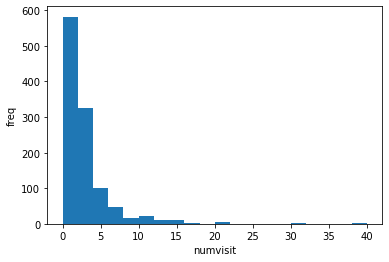

In [5]:
plt.hist(badhealth_df["numvisit"].values, bins=20)
plt.xlabel("numvisit")
plt.ylabel("freq")
_ = plt.show()

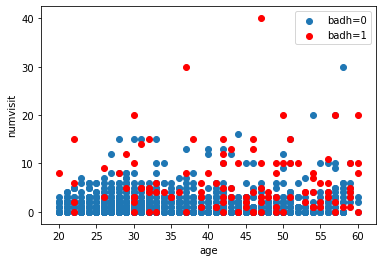

In [6]:
badhealth_badh0_df = badhealth_df[badhealth_df["badh"] == 0]
badhealth_badh1_df = badhealth_df[badhealth_df["badh"] == 1]

plt.scatter(badhealth_badh0_df["age"].values, badhealth_badh0_df["numvisit"], label="badh=0")
plt.scatter(badhealth_badh1_df["age"].values, badhealth_badh1_df["numvisit"], color="r", label="badh=1")

plt.xlabel("age")
plt.ylabel("numvisit")

plt.legend(loc="best")

_ = plt.show()

## Poisson Linear Model

Model using `pm.Poisson` as the model for `y_obs` was consistently resulting in a PyMC3 error (`ValueError: Mass matrix contains zeros on the diagonal. Some derivatives might always be zero`), which points to a modeling error, so I tried replacing the `pm.Poisson` with a `pm.NegativeBinomial` as mentioned in the course, and the sampling went through without errors.

Findings from the model

* The intercept term is not interpretable in this case.
* There is a positive relationship between `badh` and `numvisit`, i.e., people claiming to be in bad health make more hospital visits.
* There is a positive relationship between `age` and `numvisit`, i.e., older people tend to make more hospital visits.
* There is a negative relationship between the interaction term and `numvisits`, i.e., if people in good health at a given age tend to make fewer hospital visits than people with bad health and the same age.

In [7]:
model_1 = pm.Model()
with model_1:
    coeffs = pm.Normal("coeffs", mu=0, sigma=10, shape=4)

    log_preds = (coeffs[0] + 
                 coeffs[1] * badhealth_df["badh"].values + 
                 coeffs[2] * badhealth_df["age"].values + 
                 coeffs[3] * (badhealth_df["badh"] * badhealth_df["age"]).values)
    y_obs = pm.NegativeBinomial("y_obs", mu=pm.math.exp(log_preds), alpha=2.5, 
                                observed=badhealth_df["numvisit"].values)
    
    trace_1 = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coeffs]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [00:39<00:00, 614.56draws/s] 


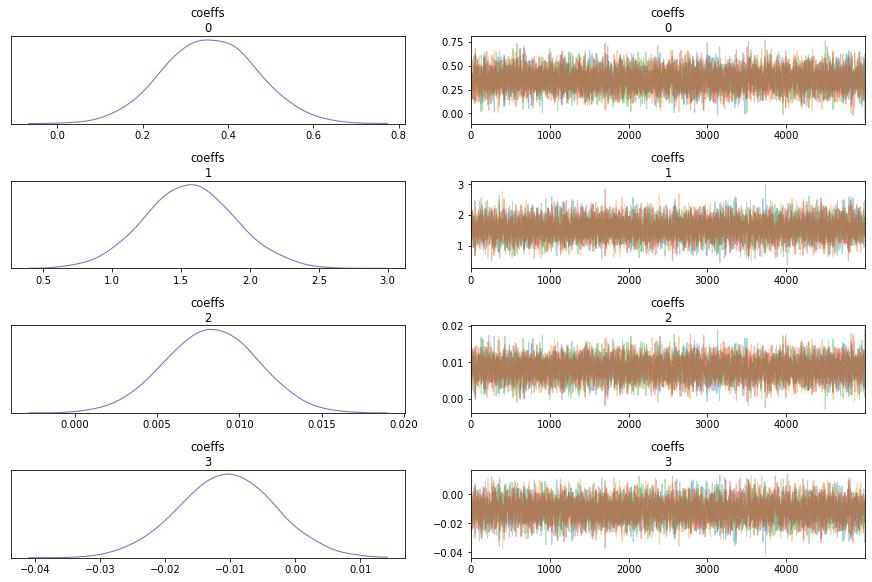

In [8]:
_ = pm.traceplot(trace_1, combined=True, compact=False)

In [9]:
pm.summary(trace_1)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
coeffs[0],0.357,0.108,0.159,0.565,0.001,0.001,6462.0,6420.0,6462.0,7986.0,1.0
coeffs[1],1.560,0.325,0.943,2.178,0.004,0.003,5778.0,5778.0,5768.0,6700.0,1.0
coeffs[2],0.008,0.003,0.003,0.013,0.000,0.000,6423.0,6406.0,6425.0,7426.0,1.0
coeffs[3],-0.011,0.007,-0.025,0.003,0.000,0.000,5672.0,5672.0,5667.0,6763.0,1.0


## Residuals

Findings:

* From the residual plot (index vs residual), it appears that the index of the data has something to do with the value of the residual, so data is probably not independent. However, in this case, the data was pre-sorted, i.e., they were ordered by the number of doctor visits.
* From the second residual plot (prediction vs residual), it looks like the model separated the predictions for patients in good health (blue dots) and patients in bad health (red dots). For people in bad health, the model predicts they will have about 6 visits, otherwise they will have about 2 visits on average.
* Residuals for the predictions, however, and quite large. Because this is a Poisson model, the variance should be the same as the expectation, i.e, 2 and 6 for the good and bad patients respectively. However, from the data, they are 7 and 41 respectively. This indicates that either the model fits poorly or data is over-dispersed for the Poisson (or NegativeBinomial) likelihood chosen.

In [10]:
coeffs = np.mean(trace_1.get_values("coeffs"), axis=0)
coeffs.shape

(4,)

In [11]:
def build_data_matrix(Xraw):
    Xones = np.ones(Xraw.shape[0]).reshape(-1, 1)
    Xint = np.multiply(Xraw[:, 0], Xraw[:, 1]).reshape(-1, 1)
    return np.hstack((Xones, Xraw, Xint)).astype(np.float32)

X = build_data_matrix(badhealth_df.values[:, -2:])
y = badhealth_df["numvisit"].values

X.shape, y.shape

((1127, 4), (1127,))

In [12]:
preds = np.exp(np.matmul(X, coeffs))
resids = y - preds

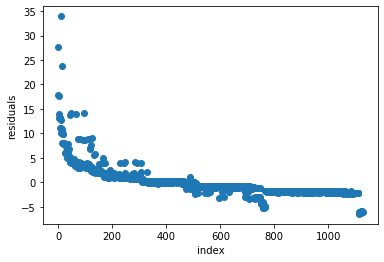

In [13]:
plt.scatter(np.arange(len(resids)), resids)
plt.xlabel("index")
plt.ylabel("residuals")
_ = plt.show()

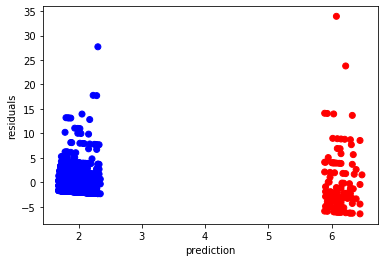

In [14]:
colors = ["b" if badh == 0 else "r" for badh in badhealth_df["badh"].values]
plt.scatter(preds, resids, color=colors)
plt.xlabel("prediction")
plt.ylabel("residuals")
_ = plt.show()

In [15]:
var_badh0 = np.var(resids[badhealth_df[badhealth_df["badh"] == 0].index.values])
var_badh1 = np.var(resids[badhealth_df[badhealth_df["badh"] == 1].index.values])
var_badh0, var_badh1

(7.015764353295999, 40.828283925186376)

## Predictive Distributions

We have 2 people age 35, one in good health and one in bad. What is the posterior probability that the individual with poor health will have more doctor visits?

Question is answered by sampling the model parameters, and for each of these, drawing samples from the likelihood.

Steps:

* using the model coefficients, compute the distribution of `lambda` parameters for the two individuals.
* this is the likelihood of the doctor visit for the two individuals.
* sample from a Poisson distribution having the `lambda` distributions computed, plot the posterior distributions.
* compute the mean of the differences to produce the answer.

The answer is `0.92`.

Because we are using posterior distributions, the estimate above takes into account the uncertainty in the model estimates. This gives a more realistic estimate than if we had just used the MLE (means) of the model parameters directly (or some other point estimate). This is one of the advantages of the Bayesian model.

In [16]:
coeffs = trace_1.get_values("coeffs")
coeffs.shape

(20000, 4)

In [17]:
p1 = np.array([1, 0, 35, 0])  # const, badh, age, badh*age for person 1
p2 = np.array([1, 1, 35, 35]) # const, badh, age, badh*age for person 2

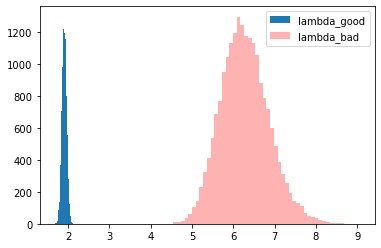

In [18]:
lambda_1 = np.exp(np.matmul(coeffs, p1))
lambda_2 = np.exp(np.matmul(coeffs, p2))

plt.hist(lambda_1, bins=50, label="lambda_good")
plt.hist(lambda_2, bins=50, color="r", alpha=0.3, label="lambda_bad")
plt.legend(loc="best")
_ = plt.show()

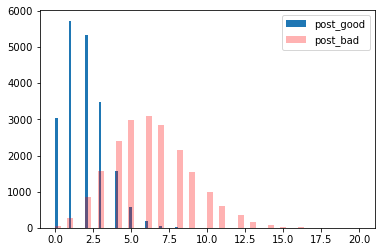

In [19]:
preds_1 = stats.poisson.rvs(mu=lambda_1, size=len(lambda_1))
preds_2 = stats.poisson.rvs(mu=lambda_2, size=len(lambda_2))

plt.hist(preds_1, bins=50, label="post_good")
plt.hist(preds_2, bins=50, color="r", alpha=0.3, label="post_bad")
plt.legend(loc="best")
_ = plt.show()

In [20]:
np.mean(preds_2 > preds_1)

0.9167

## References

* [Example of Poisson Regression](https://docs.pymc.io/notebooks/GLM-poisson-regression.html) from the PyMC3 documentation.